<a href="https://colab.research.google.com/github/AntNeedsHelp/ExplainableAI/blob/main/CNN_pneumoniaMNISTReal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 &> /dev/null
!pip3 install medmnist &> /dev/null

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.utils.data as data


from tqdm import tqdm


import medmnist
from medmnist import INFO, Evaluator

In [5]:
print(torch.__version__)

2.8.0+cu126


In [6]:
data_flag = 'pneumoniamnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 4
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [7]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
trainloader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


classes = [
    "Negative",
    "Positive",
]


for X, y in testloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"y: {y}")
    break

100%|██████████| 4.17M/4.17M [00:01<00:00, 2.70MB/s]

Shape of X [N, C, H, W]: torch.Size([4, 1, 28, 28])
Shape of y: torch.Size([4, 1]) torch.int64
y: tensor([[1],
        [0],
        [1],
        [0]])


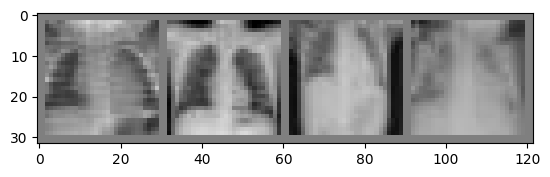

Negative Negative Positive Positive


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [9]:
import torch.nn as nn
import torch.nn.functional as F


# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)


Using cuda device


In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [11]:
def train(dataloader, model, loss_fn, optimizer, training_loss, print_size=1):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        y = torch.squeeze(y)
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % print_size == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            training_loss.append(loss)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [12]:
def test(dataloader, model, loss_fn, test_accuracy):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y = torch.squeeze(y)
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_accuracy.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {test_loss:>8f} \n")

ACTUAL TRAINING LOOP

In [13]:
epochs = 10

training_loss = []
testing_accuracy = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer, training_loss, 1000)
    test(testloader, model, loss_fn, testing_accuracy)
print("Done!")
%time

Epoch 1
-------------------------------
loss: 0.649801  [    4/ 4708]
loss: 0.728601  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.661849 

Epoch 2
-------------------------------
loss: 0.438025  [    4/ 4708]
loss: 0.567299  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.671180 

Epoch 3
-------------------------------
loss: 0.357265  [    4/ 4708]
loss: 0.330086  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.677213 

Epoch 4
-------------------------------
loss: 0.559321  [    4/ 4708]
loss: 0.548029  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.677147 

Epoch 5
-------------------------------
loss: 0.795222  [    4/ 4708]
loss: 0.545244  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.671455 

Epoch 6
-------------------------------
loss: 0.297153  [    4/ 4708]
loss: 0.306838  [ 4004/ 4708]
Test Error: 
 Accuracy: 62.50000%, Avg loss: 0.654387 

Epoch 7
-------------------------------
loss: 0.273418  [    4/ 

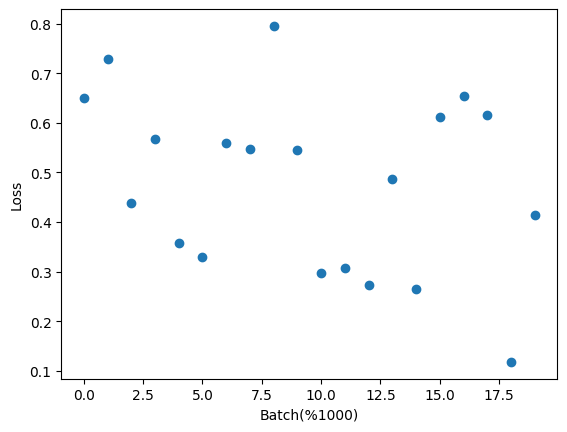

In [14]:

plt.plot(training_loss, 'o')
plt.ylabel("Loss")
plt.xlabel("Batch(%1000)")
plt.show()

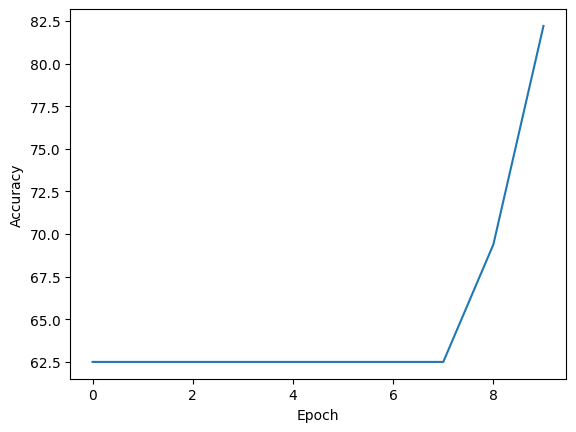

In [15]:
plt.plot(testing_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

In [16]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [17]:
import os

os.getcwd()

'/content'

In [18]:
model = Net().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [19]:
def normalize(pred):
  pred = np.log(np.exp(pred)/np.sum(np.exp(pred)))
  return pred

In [24]:
classes = [
    0, #negative
    1, #positive
]

model.eval()
index = 1
x, y = test_dataset[index][0], test_dataset[index][1]
print("TD",x.shape)

print("max",np.max(x.numpy()))
print("min",np.min(x.numpy()))


x[0, 13, 13] = 0
print(x[0][13][13])

def get_pred(x, print_val = True):
  model.eval()
  with torch.no_grad():
      x = x.to(device)
      pred = normalize(model(x[None]).cpu().numpy())

      #normalize pred ^^^^
      predicted, actual = classes[pred[0].argmax(0)], classes[y[0]]
      #if print_val:
        #print("PRED:",pred)

        #print(f'Predicted: "{predicted}", Actual: "{actual}"')
  model.train()
  return pred, (predicted, actual)

pred_array = np.zeros((x.shape[1], x.shape[2], 2))
bool_array = np.zeros((x.shape[1], x.shape[2],2))


true_array = np.zeros((x.shape[0],x.shape[1], x.shape[2]))
false_array = np.zeros((x.shape[0],x.shape[1], x.shape[2]))

change_bool_array = np.zeros((x.shape[0],x.shape[1], x.shape[2]))

#original pred values

original_pred = get_pred(x)[0]



#LIME CLONE
for i in range(x.shape[1]):
  for j in range(x.shape[2]):
    orig_value = x[0,i:i+2,j:j+2].clone().detach()
    x[0,i:i+2,j:j+2] = 0
    pred_array[i,j,:], bool_array[i,j,:] = get_pred(x)

    pred_vals, bool_vals = get_pred(x)

    pred_array[i,j,:] = pred_vals
    bool_array[i,j,:] = bool_vals

    change_bool_array[0,i,j,] = abs(bool_vals[0]-bool_vals[1])

    false_array[0,i,j] = abs(original_pred[0][0] - pred_vals[0][0])
    true_array[0,i,j] = abs(original_pred[0][1] - pred_vals[0][1])


    x[0,i:i+2,j:j+2] = orig_value
model.train()
#print(bool_array)


TD torch.Size([1, 28, 28])
max 0.6627451
min -0.42745095
tensor(0.)


Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [21]:
#for X, y in testloader:
    #print(f"Shape of X [N, C, H, W]: {X.shape}")
    #print(f"Shape of y: {y.shape} {y.dtype}")
    #print(f"Value of y {y}")

/tmp/ipython-input-3011512188.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  img_arr[(index-start)] = x


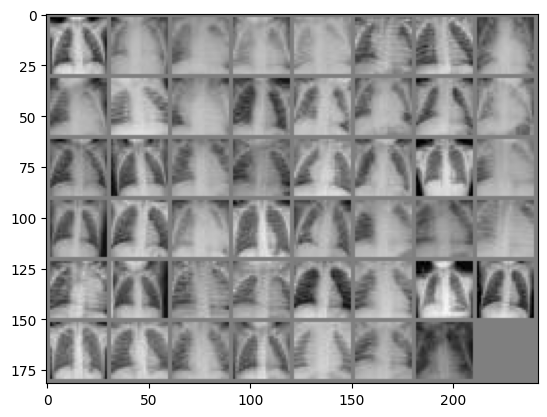

[(0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (1, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1)]


In [22]:
#SHOW PREDICTIONS FOR IMAGES
start = 3
end = 50
change = 1

img_arr = np.zeros(((end-start),1,28,28))

predss = []
for index in range(start, end, change):
  x, y = test_dataset[index][0], test_dataset[index][1]
  actual_val, pred_val = get_pred(x, False)[1]
  img_arr[(index-start)] = x
  predss.append((actual_val, pred_val))
  #print(x.shape)

img_arr = torch.tensor(img_arr)
imshow(torchvision.utils.make_grid(img_arr))
print(predss)

ORIGINAL IMAGE:


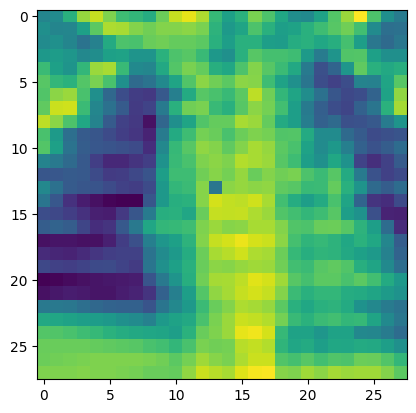

TRUE EFFECT:


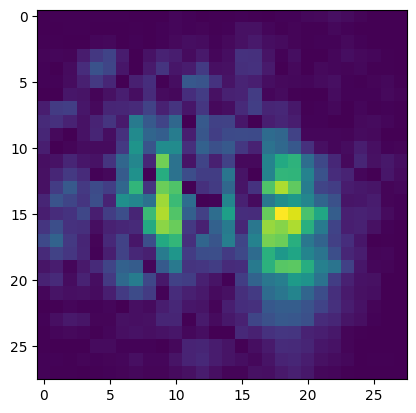

FALSE EFFECT:


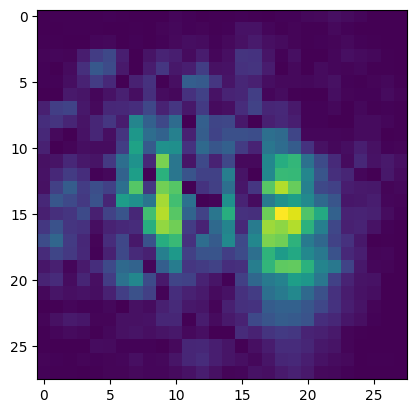

In [25]:
#VISUALIZE EFFECT OF EACH PIXEL

true_image = torch.from_numpy(true_array)
false_image = torch.from_numpy(false_array)
bool_image = torch.from_numpy(change_bool_array)
print("ORIGINAL IMAGE:")
imshow(x)
print("TRUE EFFECT:")
imshow(true_image)
print("FALSE EFFECT:")
imshow(false_image)
#print("BOOL IMAGE:")
#imshow(bool_image)


(1, 28, 28)
MAX 0.015174567699432373
MIN 0.0
ORIGINAL IMAGE:


/tmp/ipython-input-2224955289.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_rgb[0]= x[0]
/tmp/ipython-input-2224955289.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_rgb[1] = x[0]
/tmp/ipython-input-2224955289.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  x_rgb[2] = x[0]


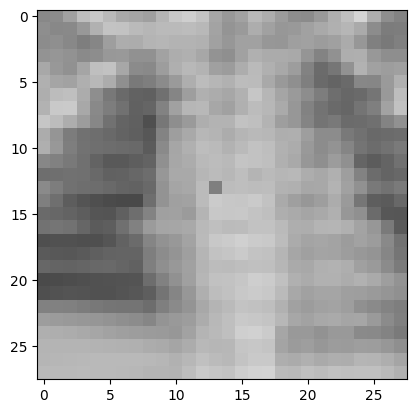

TRUE ARARAY :


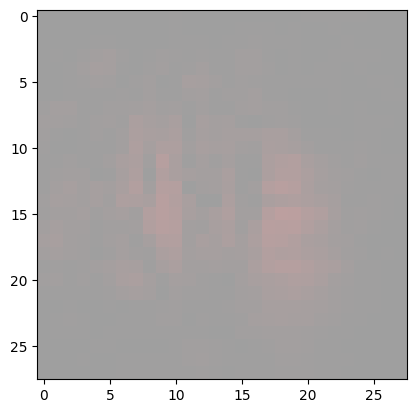

In [26]:
print(true_array.shape)
x_rgb = np.zeros((4,x.shape[1], x.shape[2]))

x_rgb[0]= x[0]
x_rgb[1] = x[0]
x_rgb[2] = x[0]
x_rgb[3] = 1

print("MAX",true_array.max())
print("MIN",true_array.min())

true_rgb = np.zeros((4,x.shape[1], x.shape[2]))




true_rgb[0]= true_array[0]*20
true_rgb[1] = 0
true_rgb[2] = 0#np.nan
true_rgb[3] = 0.5


x_rgb_image = torch.from_numpy(x_rgb)
print("ORIGINAL IMAGE:")
imshow(x_rgb_image)


true_rgb = torch.from_numpy(true_rgb)
print("TRUE ARARAY :")
imshow(true_rgb)

torch.Size([4, 28, 28])


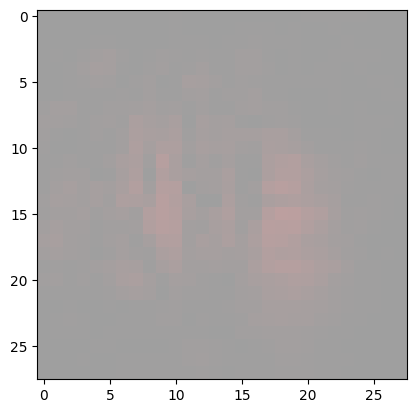

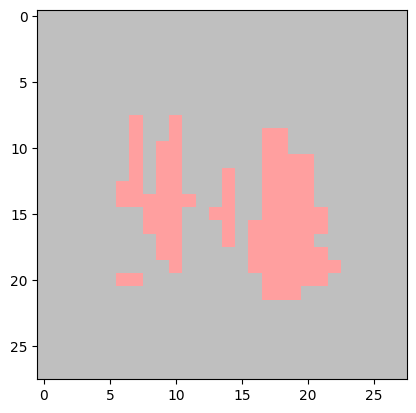

In [27]:

print(true_rgb.shape)
sorted_true = np.sort(true_rgb[0], axis=None)


#print(sorted_true)

num_disp = 100

minimum_displayed = sorted_true[sorted_true.size-num_disp]
#print(minimum_displayed)



displayed_array = np.copy(true_rgb)
displayed_array[displayed_array < minimum_displayed] = 0


displayed_array[displayed_array >= minimum_displayed] = 1


displayed_array[3][displayed_array[0] < minimum_displayed] = 0

displayed_array[3][displayed_array[0] >= minimum_displayed] = 0.5


#print("ORINGAL:")
#print(true_rgb.numpy())
#print("DISPLAYED")
#np.set_printoptions(threshold = np.inf)
#print(displayed_array)
imshow(true_rgb)
imshow(torch.from_numpy(displayed_array))

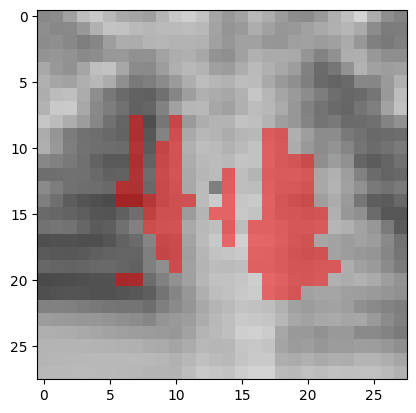

In [28]:
def overlay(img, over):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.imshow(np.transpose(over, (1, 2, 0)))
    plt.show()




overlay(x_rgb, displayed_array)